<a href="https://colab.research.google.com/github/DiwakarBasnet/Cat_and_Dog_classifier/blob/main/Models/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

# Load data from google drive into tf.dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# for removing any corrupted files from dataset
import os
import imghdr
path1 = "./drive/MyDrive/PetImages/Cat/"
path2 = "./drive/MyDrive/PetImages/Dog/"
dir_1 = os.listdir(path1)
dir_2 = os.listdir(path2)

for image in dir_1:
    file = os.path.join(path1,image)
    if not imghdr.what(file):
        os.remove(file)

for image in dir_2:
    file = os.path.join(path2,image)
    if not imghdr.what(file):
        os.remove(file) 

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./drive/MyDrive/PetImages",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    labels = "inferred",
    label_mode = "int"
)

Found 4035 files belonging to 2 classes.


# Data visualization

In [6]:
class_names = dataset.class_names
class_names

['Cat', 'Dog']

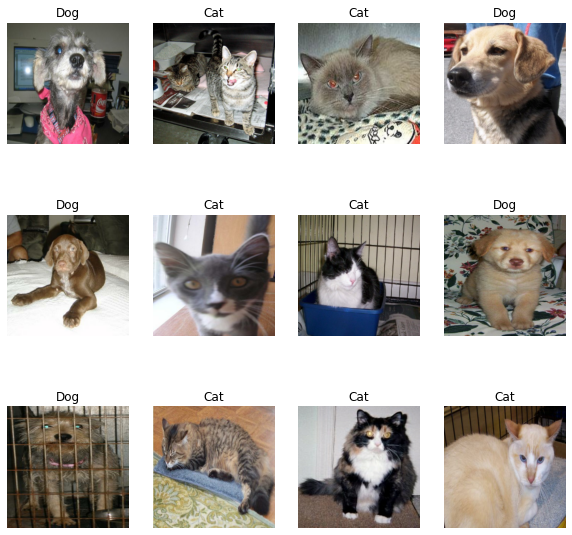

In [7]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

# Train Test Split in tensorflow

In [8]:
# 70% ==> training
# 30% ==> 15% ==> validation, 15% ==> test
# train_ds = dataset.take(547)    # train = arr[:547]
# test_ds = dataset.skip(547)     # test = arr[547:]
# val_ds = test_ds.take(117)      # val = test[:117]
# test_ds = test_ds.skip(117)     # test = test[117:]

def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, shuffle=True, shuffle_size=10000):
  
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds


In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
# .cache() -->
# reads image from disk and for next iteration when same image is needed, 
# it will keep that image in memory thus improves performance of pipeline
# .prefetch() -->
# if GPU is busy training, it will load next set of batch from disk to CPU and improves performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentaiton = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Build and train model

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
      resize_and_rescale,
      data_augmentaiton,
      layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(2, activation='sigmoid')
])

model.build(input_shape = input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [15]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
88/88 [==============================] - 50s 287ms/step - loss: 0.6937 - accuracy: 0.5013 - val_loss: 0.6877 - val_accuracy: 0.5561
Epoch 2/50
88/88 [==============================] - 12s 139ms/step - loss: 0.6883 - accuracy: 0.5436 - val_loss: 0.6879 - val_accuracy: 0.5613
Epoch 3/50
88/88 [==============================] - 12s 138ms/step - loss: 0.6866 - accuracy: 0.5569 - val_loss: 0.6882 - val_accuracy: 0.5440
Epoch 4/50
88/88 [==============================] - 12s 138ms/step - loss: 0.6831 - accuracy: 0.5640 - val_loss: 0.6750 - val_accuracy: 0.5734
Epoch 5/50
88/88 [==============================] - 12s 139ms/step - loss: 0.6665 - accuracy: 0.6003 - val_loss: 0.6517 - val_accuracy: 0.6321
Epoch 6/50
88/88 [==============================] - 12s 138ms/step - loss: 0.6630 - accuracy: 0.5985 - val_loss: 0.6729 - val_accuracy: 0.6062
Epoch 7/50
88/88 [==============================] - 12s 138ms/step - loss: 0.6674 - accuracy: 0.5996 - val_loss: 0.6567 - val_accuracy: 0.5924

In [18]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 13s 57ms/step - loss: 0.4280 - accuracy: 0.8125


# Plot training history on graph

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

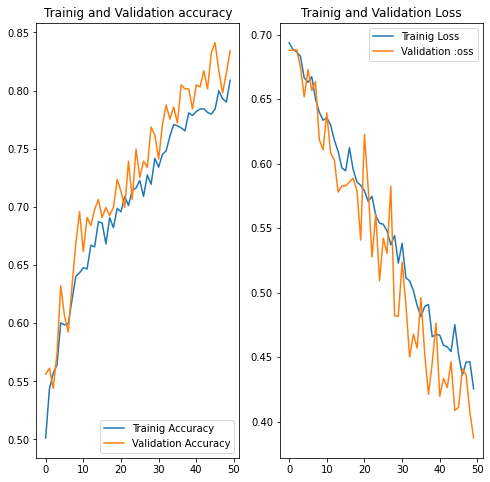

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Trainig Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Trainig and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Trainig Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation :oss')
plt.legend(loc='upper right')
plt.title('Trainig and Validation Loss')

plt.show()

# Predictions on sample images

In [21]:
# for images_batch, labels_batch in test_ds.take(1):

#   first_image = images_batch[0].numpy().astype('uint8')
#   first_label = labels_batch[0].numpy()

#   print("First image to predict")
#   plt.imshow(first_image)
#   print("Actual label:",class_names[first_label])

#   batch_prediction = model.predict(images_batch)
#   print("Predicted label:",class_names[np.argmax(batch_prediction[0])])             # argmax gives argument highest number

In [22]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)    # create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  
  return predicted_class, confidence

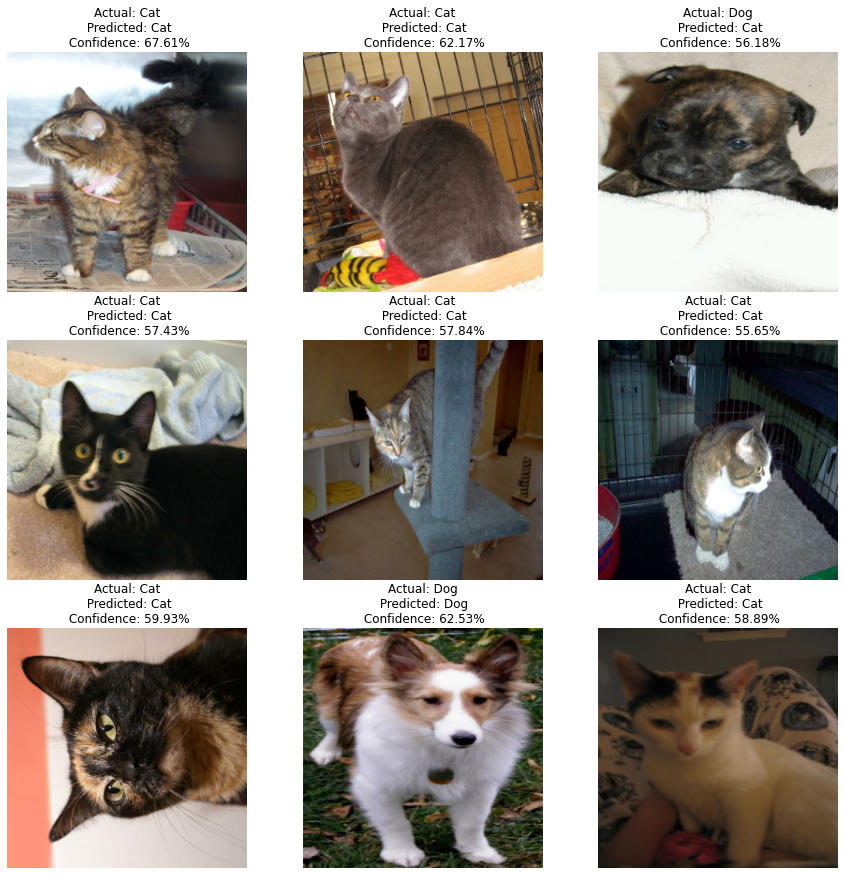

In [23]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}%")
    plt.axis("off")

In [24]:
# saving the model
model_name = "binary_cat_dog_classifier"
model.save(f"./drive/MyDrive/Models/{model_name}")

INFO:tensorflow:Assets written to: ./drive/MyDrive/Models/binary_cat_dog_classifier/assets
